# Machine Learning Titanic 
Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The gradient classifier and logistic regression are the best two models that provide the highest best score. Interestingly, the gradient classifier does not have a high AUC but the results cross validate into the test dataset without overfitting the data. For example, decision tree can get an almost perfect AUC but when you cross validate the data it is clearly overfiting. 

# Metrics
The AUC regression results:
* Logistic  0.8759
* Linear    0.8765
* Graident  0.8739
* Decision  0.8667
* Forest    0.8503
* XGB       0.7829 with MSE 0.1940
* Knn       0.645
* SVM       0.5941 

The AUC classifier results:
* Forest   Classifier     0.8503 || MAE  0.19
* Gradient Classifier     0.7609 || MSE 0.2090
* Decision Classifier     0.7345 || MSE  0.4771 
* KNN      Classifier     0.5975 || MSE  0.5325

# Train Data
Train.csv will contain the details of a subset of the passengers on board (891 to be exact) and whether they survive or not. The shape of the train data is (891, 12). 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from statistics import mean
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
from math import sqrt

train=r'/kaggle/input/titanic/train.csv'
test=r'/kaggle/input/titanic/test.csv'

df=pd.read_csv(train)
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [3]:
#Check Duplicates:
dupstr = df.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))
df[dupstr]

Total no of duplicate values in Training Dataset = 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [4]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
dtype: float64


# Feature Engineer
We need to replace male and female into numbers. This is a very important part of the process because gender is one of the highest predictors on if a person survived or not.

In [5]:
#GENDER
df['Sex']=df['Sex'].map({'female':0,'male':1})

Females whose number is 0 had a much higher chance of surving than males. Later on, doing the importance feature analysis we will view that gender is actually one of the highest predictors. 

In [6]:
genderTable = pd.crosstab(df['Survived'],df['Sex'])
genderTable

Sex,0,1
Survived,,
0,81,468
1,233,109


#### Embarked: 
There are three classes C, Q, and S. Class C seems to have the highest chance of survival. Class S has the lowest chance of survival. Unfornately this would tend to show that economic status seems to played a part in the decision if someone survived or not. Embarked is hard to categorize and often just makes the accuracy go down. Therefore, for now I have removed the idea of using this as a feature.

In [7]:
"""
#df['Embarked'].unique() #array(['S', 'C', 'Q', nan], dtype=object)
df['Embarked'].fillna(0)
embarkedTable = pd.crosstab(df['Survived'],df['Embarked'])

# The best classes by survival are C Q S so I gave them points in that order:
df['Embarked']=df['Embarked'].map({'C':2,'Q':1, 'S':0})
df.head()
"""

"\n#df['Embarked'].unique() #array(['S', 'C', 'Q', nan], dtype=object)\ndf['Embarked'].fillna(0)\nembarkedTable = pd.crosstab(df['Survived'],df['Embarked'])\n\n# The best classes by survival are C Q S so I gave them points in that order:\ndf['Embarked']=df['Embarked'].map({'C':2,'Q':1, 'S':0})\ndf.head()\n"

# Examine Target Variable
Survived is the Y variable we will be analyzing. Since the survival rete is 0.384 the data is not considered unbalanced. 

In [8]:
temp=df['Survived'].value_counts()
print(temp)
no=temp[0]
yes=temp[1]
percent=round(yes/(yes+no),3)
print("Percent that survived: ", percent)

0    549
1    342
Name: Survived, dtype: int64
Percent that survived:  0.384


# Numeric DataFrame
For now, we will analyze only numeric values. Categorical values will need to be encoded or analyzed individually.

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,1,22.0,1,0,7.2500
1,2,1,1,0,38.0,1,0,71.2833
2,3,1,3,0,26.0,0,0,7.9250
3,4,1,1,0,35.0,1,0,53.1000
4,5,0,3,1,35.0,0,0,8.0500


# Check for missing values
Age is missing around 20% of values.Therefore, we can simply fill in the mean for that one column.

In [10]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(df)
    print(findNA.head())
findNA() 

Missing data by column as a percent:
Age            0.198653
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
dtype: float64


In [11]:
df= df.fillna(df.mean())

# Split Data

In [12]:
X=df.drop('Survived', axis=1)
y=df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42)

# Highly Correlated Features
There are no highly correlated variables above 80%. Therefore, we do not need to be concerned about removing variables that are too highly correlated. 

# Gradient Boost 

#### Cross Validate 

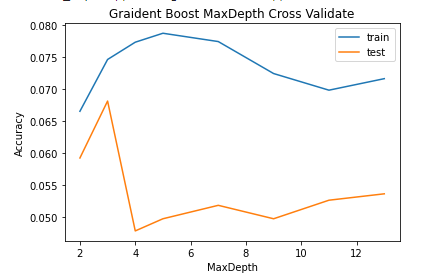

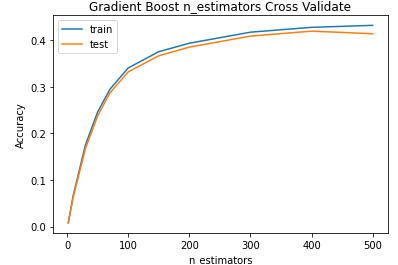

The four parameters I tunned are max_depth, n_estimators, min_sample_split and learning_rate:

* The best max_depth is 2
* The best n_estimators is 500
* The best min_sample_split with least amount of error was at 7
* Having a higher learning rate makes AUC worse so I set it at .01

The full parameter reports are below: <br>
* 2  max_depth || AUC  0.8739  || MSE 0.1378
* 3  max_depth || AUC  0.8689  || MSE 0.1410
* 4  max_depth || AUC  0.86  || MSE 0.1407
* 5  max_depth || AUC  0.8567  || MSE 0.1485
* 100  n_estimators || AUC  0.8632  || MSE 0.1600
* 200  n_estimators || AUC  0.8726  || MSE 0.1471
* 300  n_estimators || AUC  0.8703  || MSE 0.1414
* 400  n_estimators || AUC  0.8732  || MSE 0.1389
* 500  n_estimators || AUC  0.874  || MSE 0.1378
* 2  min_samples_splits || AUC  0.8739  || MSE 0.1378
* 3  min_samples_splits || AUC  0.8738  || MSE 0.1378
* 5  min_samples_splits || AUC  0.8739  || MSE 0.1378

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5, 7, 9, 11, 13]
    accList=[]
    cvList=[]
    
    for d in depthList:
        params = {
         "n_estimators": 10, "max_depth": d, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        
        gbR2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, gb.predict(X_test))
        print(d, " max_depth || GB reg r2: ", gbR2, "|| MSE: {:.4f}".format(mse)) 
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 5, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        
        cvList.append(gbCV)
        accList.append(gbScore)
        
    plt.plot(depthList,accList, label="train")
    plt.plot(depthList,cvList, label="test")
    plt.title('Graident Boost MaxDepth Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

def gbN():
    nList=[2, 10, 30, 50, 70, 100, 150, 200, 300, 400, 500]
    accList=[]
    cvList=[]
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 2, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        
        gbR2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, gb.predict(X_test))
        print(n, "n_estimators || GB r2: ", gbR2, "|| MSE: {:.4f}".format(mse)) 
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 4, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        print("GB Score: ", gbScore  ,"||" , gbCV, "cross validate.")
        
        accList.append(gbScore)
        cvList.append(gbCV)
    
    plt.plot(nList,accList, label="train")
    plt.plot(nList,cvList, label="test")
    plt.title('Gradient Boost n_estimators Cross Validate')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
def gbSplit():
    nList=[2, 3, 5, 7, 9]
    accList=[]
    cvList=[]
    
    for n in nList:
        params = {
         "n_estimators": 100, "max_depth": 2,
            "min_samples_split": n, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        gb_r2 = r2_score(y_test, y_pred).round(4)
        mse = mean_squared_error(y_test, gb.predict(X_test)).round(4)
        print(n," min_samples_splits || R2 ", gb_r2, " || MSE {:.4f}".format(mse))
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 4, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        print("GB Score: ", gbScore  ,"||" , gbCV, "cross validate.")
        
        accList.append(gbScore)
        cvList.append(gbCV)
    
    plt.plot(nList,accList, label="train")
    plt.plot(nList,cvList, label="test")
    plt.title('Gradient Boost min_split Cross Validate')
    plt.xlabel('min_split')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

#### Gradient Boost Prediction
Use functions above to find the best paramters to input below.

In [14]:
params = {
 "n_estimators": 500, "max_depth": 3, 
    "min_samples_split": 7, "learning_rate": 0.01,
}

#Fit and Predict:
xgb = ensemble.GradientBoostingClassifier(**params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

#AUC of model
xgbAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for gradient boost is: ", xgbAUC)

xgbMSE = mean_squared_error(y_test, xgb.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(xgbMSE))

xgbScore = xgb.score(X_test, y_test).round(4)  # train test 
xgbCV = cross_validate(xgb, X, y, cv = 4, scoring= 'r2')
xgbCV=xgbCV['test_score'].mean().round(4)
print("GB Score: ", xgbScore  ,"||" , xgbCV, "cross validate.")

Gradient boosting regression r2:  0.2003
AUC for gradient boost is:  0.7842
The mean squared error (MSE) on test set: 0.1940
GB Score:  0.806 || 0.0983 cross validate.


# Feature Importance

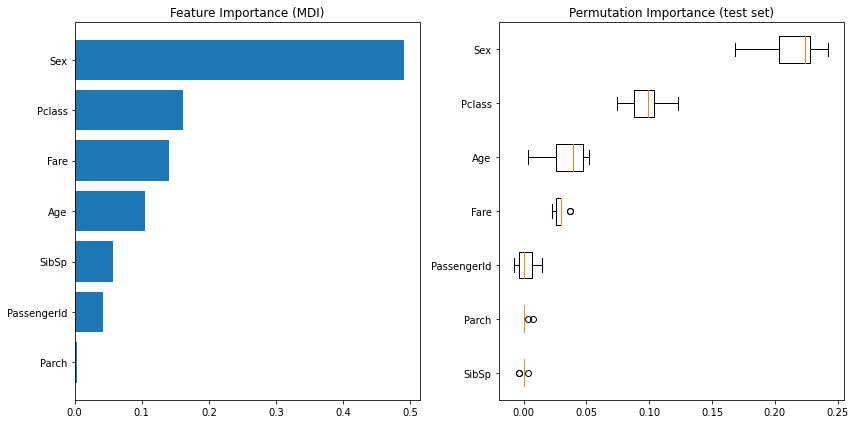

In [15]:
cols=X.columns
feature_importance = xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    xgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# XGBOOST

In [16]:
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

def xgbN():
    depthList=[2, 3, 4, 5, 7, 9, 11, 13]

    for d in depthList:
        xgb = xgb.XGBRegressor(n_estimators=100, max_depth=d)
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)

        #calculate AUC of model
        xgbAUC = round( metrics.roc_auc_score(y_test,  y_pred), 4 ) 
        print("AUC for XGB is: ", xgbAUC)

        xgbMSE = mean_squared_error(y_test, y_pred)
        print("MSE XGB on test set: {:.4f}".format(xgbMSE))

def xgbN():
    nList=[2, 10, 30, 50, 70, 100, 150, 200, 300, 400]
    accList=[]
    cvList=[]
    for n in nList:
        xgb = xgb.XGBClassifier(
         n_estimators= n,
         max_depth= 4,
         min_child_weight= 2,
         gamma=0.9,                        
         objective= 'binary:logistic'
        )

        #Fit and Predict:
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)

        #calculate AUC of model
        xgbAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        print("AUC for XGB is: ", xgbAUC)

        xgbMSE = mean_squared_error(y_test, y_pred)
        print("MSE XGB on test set: {:.4f}".format(xgbMSE))

#Turn on or off functions here:
#xgbDepth()
#xgbN()

In [17]:
xgb = xgb.XGBClassifier(
 n_estimators= 200,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 objective= 'binary:logistic'
)

#Fit and Predict:
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

#calculate AUC of model
xgbAUC = round( metrics.roc_auc_score(y_test, xgb_pred), 4 ) 
print("AUC for XGB is: ", xgbAUC)

xgbMSE = mean_squared_error(y_test, xgb_pred)
print("MSE XGB on test set: {:.4f}".format(xgbMSE))

AUC for XGB is:  0.7829
MSE XGB on test set: 0.1940


# Logistic Regression
AUC for logistic regression is:  0.8779. Tuning the C value did not seem to make much difference in the final AUC prediction. 

#### Parameters Tuning
The Parameter C, the Grid Search is a way to tune the data. C parameter at 10 seems to give the highest AUC but it does not make much difference. The C parameter report gives the following:
* 0.01  C param || AUC:  0.8603  || MAE 0.2819
* 1  C param || AUC:  0.8759  || MAE 0.2819
* 2  C param || AUC:  0.8771  || MAE 0.2819
* 5  C param || AUC:  0.8778  || MAE 0.2819
* 10  C param || AUC:  0.8779  || MAE 0.2819


In [18]:
from sklearn.linear_model import LogisticRegression
#Note: solver param gets rid of encoder error

def logC():
    cList=[.01, 1, 2, 5, 10]
    for n in cList:
        logReg = LogisticRegression(solver='liblinear', C=n) 

        logReg.fit(X_train, y_train)
        logPredict = logReg.predict_proba(X_test)[::,1]

        auc = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
        mae = mean_absolute_error(y_test, y_pred).round(4)
        print(n, " C param || AUC: ", auc, " || MAE", mae) 
#logC()

#### Final Logistic Prediction
Input the variables below from using the test functions above. Using l1 or l2 for penalty does not make a major difference in final AUC.

In [19]:
num=10
logReg = LogisticRegression(solver='liblinear',penalty='l2', C=num) 

#Train the model and create predictions
logReg.fit(X_train, y_train)
logPredict = logReg.predict_proba(X_test)[::,1]

#calculate AUC of model
xgbAUC = round( metrics.roc_auc_score(y_test, logPredict), 4 ) 
print("AUC for logistic regression is: ", xgbAUC)

AUC for logistic regression is:  0.8779


# Linear Regression

AUC for linear regression is:  0.8765
Linear regression r2 score:  0.4424
Linear Accuracy:  0.4424
0.3665  linear regression cross validate mean
0.3678  is lr MSE 


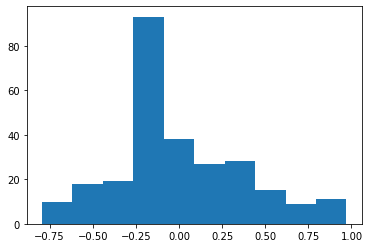

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

#Linear Metrics:
xgbAUC = round( metrics.roc_auc_score(y_test, lrPredict), 4 ) 
r2 = r2_score(y_test, lrPredict).round(4) 
print("AUC for linear regression is: ", xgbAUC)
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

lrMSE=np.sqrt(metrics.mean_squared_error(y_test, lrPredict))
print(round(lrMSE, 4), " is lr MSE ")

def linearReports():
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)

# Decision Tree

#### max_leaf_nodes
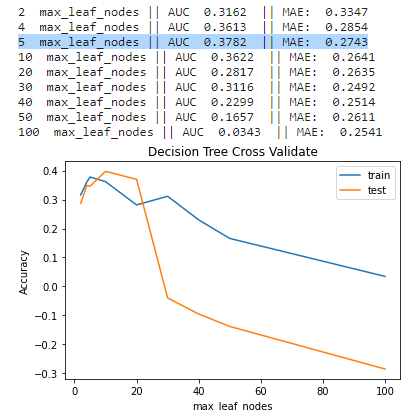

#### max_depth
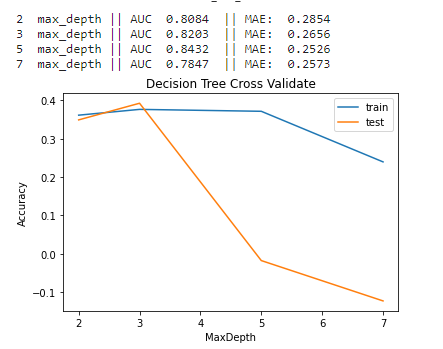

The results after 3 for max_depth are underfit. Therefore, the best max_depth to use seems to be 2 or 3.

Best parameters are:
* max_leaf_nodes=5  
* max_depth=2


2  max_leaf_nodes || AUC  0.3162  || MAE:  0.3347
4  max_leaf_nodes || AUC  0.3613  || MAE:  0.2854
5  max_leaf_nodes || AUC  0.3782  || MAE:  0.2743
10  max_leaf_nodes || AUC  0.3622  || MAE:  0.2641
20  max_leaf_nodes || AUC  0.2817  || MAE:  0.2635
30  max_leaf_nodes || AUC  0.3116  || MAE:  0.2492
40  max_leaf_nodes || AUC  0.2299  || MAE:  0.2514
50  max_leaf_nodes || AUC  0.1657  || MAE:  0.2611
100  max_leaf_nodes || AUC  0.0343  || MAE:  0.2541


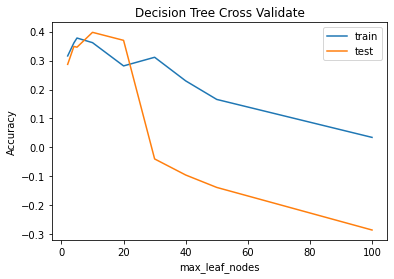

2  max_depth || AUC  0.8084  || MAE:  0.2854
3  max_depth || AUC  0.8203  || MAE:  0.2656
5  max_depth || AUC  0.8432  || MAE:  0.2526
7  max_depth || AUC  0.7847  || MAE:  0.2573


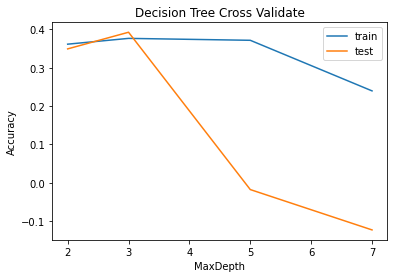

In [21]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    leafList = [2, 4, 5, 10, 20, 30, 40, 50, 100]
    maeDic={} #dictionary  key=leaf  mae=value
    
    accList=[]
    cvList=[]
    maeList=[]
    maxLeafNodesList=[]
    for leaf in leafList:
        tree = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)
        maeDic[leaf]=mae
        print(leaf, " max_leaf_nodes || AUC ", treeR2, " || MAE: ", mae)
        
        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        accList.append(treeScore)

    plt.plot(leafList,accList, label="train")
    plt.plot(leafList,cvList, label="test")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    maxLeafNodes = sorted(maeDic, key=lambda x : maeDic[x])[0]
    
    
def calcDepth():
    maxDepthList = [2, 3, 5, 7]
    
    maeDic={} #dictionary  key=depth  mae=value
    accList=[]
    cvList=[]
    maeList=[]
    maxLeafNodesList=[]
    
    for d in maxDepthList:
        tree = DecisionTreeRegressor(max_leaf_nodes=100, max_depth=d, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
        treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
        print(d, " max_depth || AUC ", treeAUC, " || MAE: ", mae)
        
        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        accList.append(treeScore)

    plt.plot(maxDepthList,accList, label="train")
    plt.plot(maxDepthList,cvList, label="test")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()         
    
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    #print(best_max_depth, " best max_depth with least error.") 
    
def automateTree():
    candidate_max_leaf_nodes = [2, 5, 10, 25, 50, 80, 100, 200, 300]
    max_depth_list = [2, 3, 5, 7, 9]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, 
                                          max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeR2 = r2_score(y_test, y_pred).round(4)
            
            aucList.append(treeR2)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['AUC'], ascending=False)
    return df

#TURN FUNCTION OFF OR ON BELOW:   
calcLeaf()
calcDepth()
#treeDF=automateTree()    
#treeDF.head()

#### Final Decision Tree Prediction
Inputs below such as best_depth by using functions above.

In [22]:
maxLeafNode=5
best_depth=2
    
#MAKE PREDICTION:
tree = DecisionTreeClassifier(max_depth=best_depth, max_leaf_nodes=maxLeafNode, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#Calculate Metrics:
treeR2 = r2_score(y_test, y_pred).round(4)
print(treeR2, " R2 Decision Tree")
treeAUC = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("AUC for decision tree is: ", treeAUC)
treeMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(round(treeMSE, 4), " is tree MSE ")

0.0619  R2 Decision Tree
AUC for decision tree is:  0.7345
0.4771  is tree MSE 


# Random Forest
Random forest AUC:  0.8503 which is good results considering forest does not overfit data.

#### max_depth 
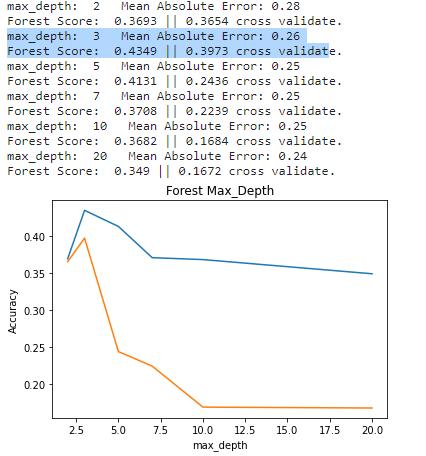

#### num_estimators
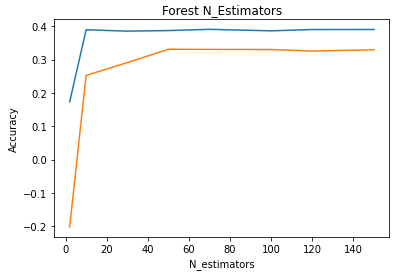

The best n_estimates with high AUC seems to be 400. Error is not impacted by the change of n_estimates. The full report can be seen below: <br>
* 2  n_estimates |  0.7962  AUC |  0.24  MAE
* 102  n_estimates |  0.843  AUC |  0.25  MAE
* 202  n_estimates |  0.8459  AUC |  0.25  MAE
* 302  n_estimates |  0.8492  AUC |  0.25  MAE
* 402  n_estimates |  0.8505  AUC |  0.25  MAE
* 502  n_estimates |  0.8489  AUC |  0.25  MAE

In [23]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#Check for Error and find Best n_estimators:
def forestNumEst():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in [2, 4, 6, 8, 10, 30, 50, 70]:
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nEst,accList, label="test")
    plt.plot(nEst,cvList, label="train")
    plt.title("Forest N_Estimators")
    plt.xlabel('N_estimators')
    plt.ylabel('Accuracy')
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)
    
def forestDepth():
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in [2, 3, 5, 7, 10, 20]:
        forest = RandomForestRegressor(n_estimators=10, max_depth=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("max_depth: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nEst,accList, label="test")
    plt.plot(nEst,cvList, label="train")
    plt.title("Forest Max_Depth")
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMAE)

#forestNumEst() 
#forestDepth()

#### Final Random Forest Prediction

In [24]:
forestEst=100
forestDepth=3

forest = RandomForestClassifier(n_estimators=forestEst, max_depth=forestDepth, random_state = 0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forest_r2 = r2_score(y_test, y_pred).round(4)  
forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
print("Random forest AUC: ", forest_auc) 
print("Random forest r2: ", forest_r2)

mae=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Random forest MAE: ", mae)

Random forest AUC:  0.7519
Random forest r2:  0.1081
Random forest MAE:  0.22


# K-Nearest Neighbors (KNN)

#### KNN Parameter Tunning

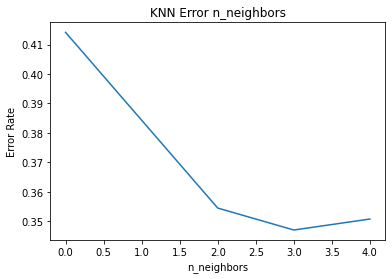

In [25]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

def knnError():
    error_rates = []
    for i in range(1, 10, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))
    plt.figure(figsize=(6,4))
    plt.plot(error_rates)
    plt.title("KNN Error n_neighbors")
    plt.xlabel("n_neighbors")
    plt.ylabel("Error Rate")
knnError()

#### Final KNN Prediction

In [26]:
KNNnum=3 #Input from knnError function

#Train the model and make predictions:
knn = KNeighborsClassifier(n_neighbors =KNNnum) 
knn.fit(X_train, y_train)
knnPredict = knn.predict_proba(X_test)[::,1]

#calculate AUC of model
knn_auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
print("Knn AUC: ", knn_auc)
error = round(sqrt(mean_squared_error(y_test,knnPredict)), 4)
print("MSE ", error)

Knn AUC:  0.5975
MSE  0.5325


# Support Vector 
The initial results for SVM AUC with no parameter tunning is 0.5336.  The model does not seem worth investing lots of time into due to poor AUC performance. 

#### GridSearch Tune
The best parameters from tunning SVM is SVC(C=1000, gamma=0.0001).

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
 
def tuneSVM():
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

#### Final SVM Prediction

In [28]:
#Fit and Predict:
def runSVM():
    svm=SVC(C=1000, gamma=0.0001, kernel = 'linear')
    svm.fit(X_train, y_train)
    svmPedict = svm.predict(X_test)
    np.shape(svmPedict)
    np.shape(y_test)
    #y_class = np.argmax(y_pred, axis = 0)

    #calculate AUC of model
    svmAUC = round( metrics.roc_auc_score(y_test, svmPedict, multi_class='ovr'), 4 ) 
    print("SVC AUC is: ", svmAUC)

    svmR2 = r2_score(y_test, svmPedict).round(4) 
    print("SVM r2: ", svmR2) 

    svmMAE=metrics.mean_absolute_error(y_test, svmPedict)
    
    plt.figure(figsize=(5, 7))
    ax = sns.distplot(y, hist=False, color="r", label="Actual Value")
    sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax)
    plt.title('Actual vs Fitted Values')
    plt.show()
    plt.close()

# Test Data

In [29]:
test=pd.read_csv(test)

#GENDER
test['Sex']=test['Sex'].map({'female':0,'male':1})

#EMBARKED
#test['Embarked']=test['Embarked'].map({'C':2,'Q':1, 'S':0})

features=list(X.columns)
test=test[features]

test=test.fillna(test.mean())
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,1,34.5,0,0,7.8292
1,893,3,0,47.0,1,0,7.0000
2,894,2,1,62.0,0,0,9.6875
3,895,3,1,27.0,0,0,8.6625
4,896,3,0,22.0,1,1,12.2875


# Final Prediction

In [30]:
test_predictions = forest.predict(test)
passID=test['PassengerId']
tupleData = list(zip(passID, test_predictions))
output = pd.DataFrame(tupleData, columns = ['PassengerId', 'Survived'])
output.head(7)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0


In [31]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


#### Notes:
Being a wife makes no difference in the final prediction: <br>
` df['Titles'] = df['Name'].str.extract(r', (\w+\.)') 
df['Titles'] = df['Titles'].apply(lambda x: 1 if x=='Mrs.' else 0) `